# Telluric clone figure for the paper

Here we make a clone of a TelFit model for a figure for the paper.  This figure is based directly off of the Step2 tutorial.

In [1]:
import torch
from blase.emulator import SparseLogEmulator
from gollum.telluric import TelFitSpectrum
import numpy as np
%config InlineBackend.figure_format='retina'

In [2]:
device = "cuda" # Change to "cuda" if you happen to have an NVIDIA GPU available.

#### Set the wavelength limits
Here we choose a small region to match the previous stellar spectrum demo.

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic telluric spectrum

In [4]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [5]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()

In [6]:
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) & 
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

Great! Let's clone the telluric spectrum with the LogEmulator.

In [7]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`

Below about `-15` in `ln` space, the flux becomes dominated by **numerical artifacts**.  That's okay, we will never perceive flux that is less than a ten-millionth of the continuum, so we can simply chop it off.  

In [8]:
telluric_lnflux[telluric_lnflux < -15] = -15

The emulate takes in the spectrum and finds all the "prominent" spectral lines above some `prominence` threshold.  A prominence threshold of `0.01` roughly corresponds to absorption lines that are 1% below the continuum.  

We use a **logarithmic** emulator for telluric lines because some spectral lines are so saturated that they appear to have nearly flat bottoms asymptotically approaching `0.0`.  Linear emulators tend to break in this saturated regime.

In [9]:
%%capture
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, 
                             wing_cut_pixels=6000, prominence=0.01, device=device)

In [11]:
emulator.to(device)

SparseLogEmulator()

The coarse initialization of the emulator yields lousy clones, just like we saw in the stellar cloning example.  Nevertheless, let's spotcheck what the spectrum looks like:

In [12]:
with torch.no_grad():
    telluric_pre = emulator.forward().cpu().numpy()

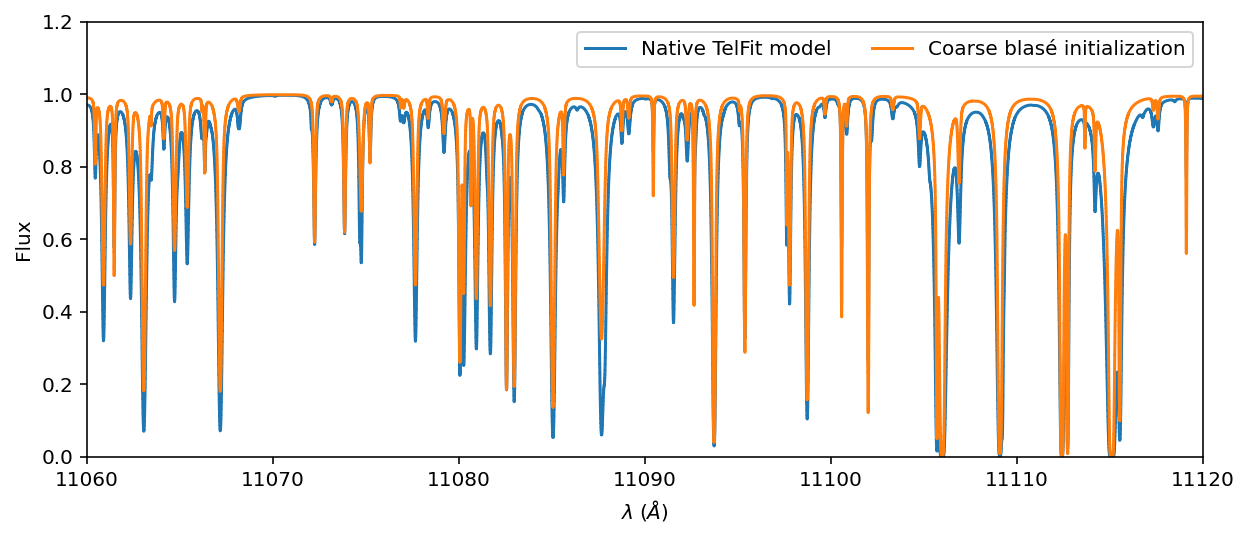

In [13]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_pre, label='Coarse blasé initialization')
ax.set_xlim(11_060, 11_120)
ax.legend(loc='upper right', ncol=2);

As we expected, the clone does not match the native resolution `TelFit` model.  We will *fine-tune* the cloned line properties to make the match nearly pixel-perfect.  That process is sometimes referred to as *optimization*.

## Fine-tuning the spectral line properties

One neat aspect of PyTorch is that it's easy to fix parameters in the optimization process. You simply turn off the gradients of some parameter.  Operationally, this simple switch makes it so that those `requires_grad = False` parameters cannot "sense" the direction to a better fit and so they simply stay where they are.   

Here we fill fix the *line center positions* $\lambda_0$, and vary the amplitude, width, and shape of each Voigt profile.

In [14]:
emulator.lam_centers.requires_grad = False
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

We choose 100 epochs and a learning rate `LR` of 0.05, favoring speed over precision.  We recommend training for more epochs with a finer learning rate if you are unsatisfied with the precision you obtain.

In [52]:
emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00015155: 100%|███████████████████████████| 1000/1000 [00:11<00:00, 86.53it/s]


Those 100 epochs took about 90 seconds on my M1 Macbook Air.  We can now examine the fine-tuned forward model.

In [19]:
with torch.no_grad():
    telluric_post = emulator.forward().cpu().numpy()

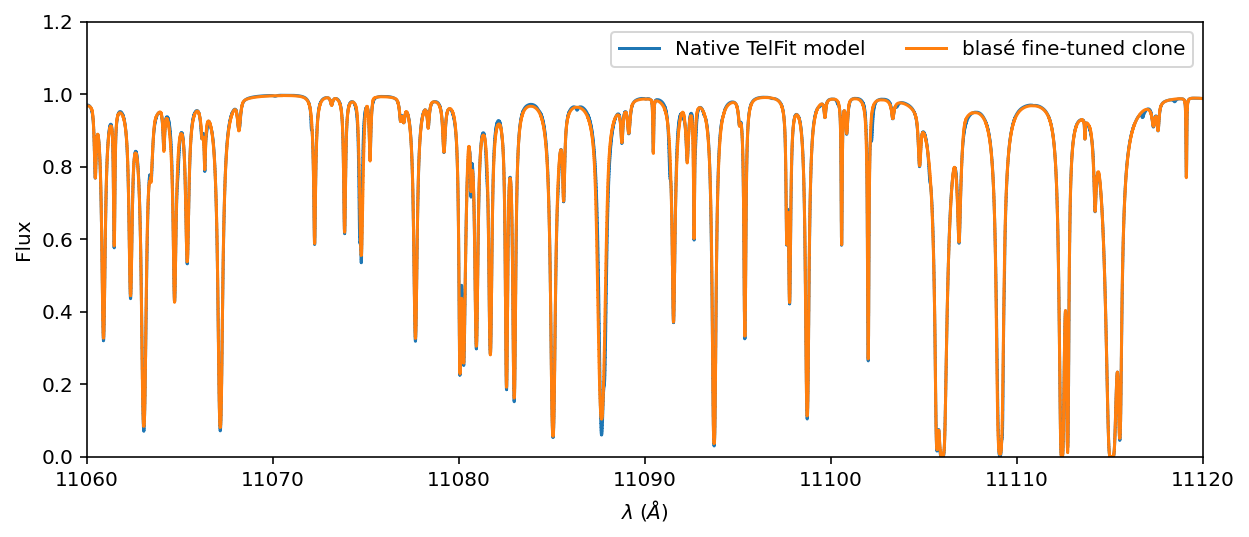

In [20]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_post, label='blasé fine-tuned clone')
ax.set_xlim(11_060, 11_120)
ax.legend(loc='upper right', ncol=2);

## Make a twin-axis plot for the paper, showing before and after

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

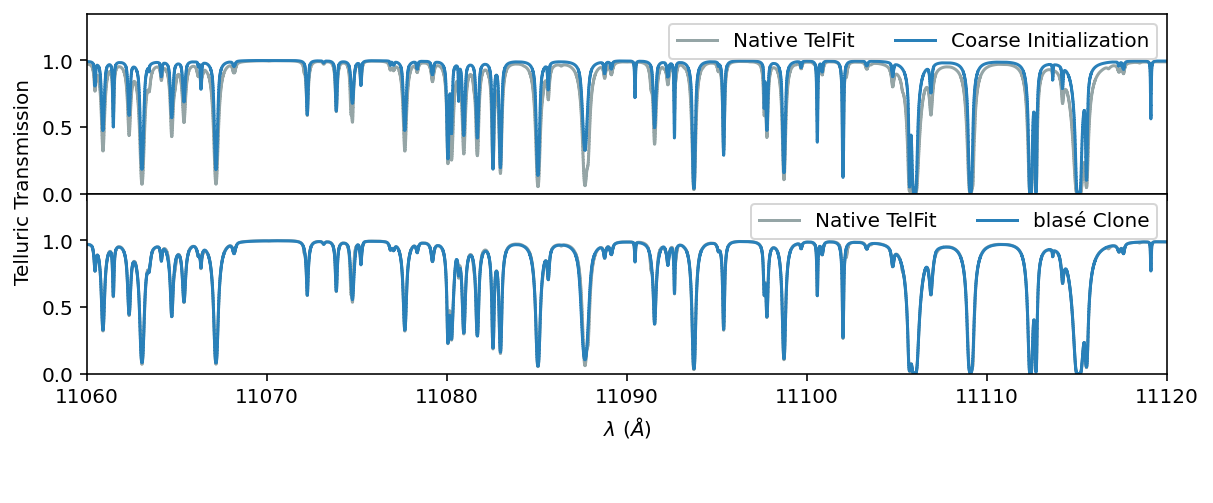

In [51]:
fig, axes = plt.subplots(nrows=2, figsize=(7.5, 2.5), sharex=True, squeeze=True)


ylo, yhi = 0, 1.35

ax = axes[0]
telluric_spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native TelFit', color='#95a5a6')
ax.step(emulator.wl_native, telluric_pre, label='Coarse Initialization', color='#2980b9')
ax.set_ylim(ylo, yhi)
ax.legend(loc='best', ncol=2)
ax.set_yticks([0, 0.5, 1])


ax = axes[1]
telluric_spectrum.plot(ax=ax, ylo=0, yhi=1.1, label='Native TelFit', color='#95a5a6')
ax.step(emulator.wl_native, telluric_post, label='blasé Clone',  color='#2980b9');
#ax.step(wavelength_grid, telluric_post, label='Telluric Semi-empirical');
ax.legend(loc='best', ncol=2)
ax.set_xlim(11_060, 11_120);
ax.set_ylim(ylo, yhi)
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('                                Telluric Transmission')
ax.set_xlabel('$\lambda ~ (\AA)$')

fig.subplots_adjust(0,0,1,1,0,0)
plt.savefig('../../paper/paper1/figures/TelFit_clone_2panel.pdf', bbox_inches='tight')

In [21]:
#torch.save(emulator.state_dict(), "telfit_clone_temp290_hum040_prom0p01_11000Ang.pt")